In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import functools
import time

from network_class import *
from utils import *


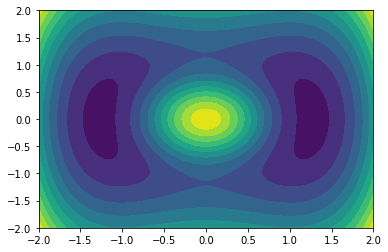

In [2]:

def u(x,DELTA=0.125):
    x0 = x[:, 0]
    x1 = x[:, 1]
    return 1/2*(x0**2-1)**2 + x1**2 + 1/DELTA*torch.exp(-(x0**2+x1**2)/DELTA/4)

def grad_u(x,DELTA=0.125):
    x0 = x[:, 0]  # 取所有batch的第一个维度
    x1 = x[:, 1]  # 取所有batch的第二个维度
    grad_x0 = 1 * (x0**2 - 1) * 2 * x0 - (2 * x0 / DELTA) * torch.exp(-(x0**2 + x1**2) / DELTA /4)
    grad_x1 = 2 * x1 - (2 * x1 / DELTA) * torch.exp(-(x0**2 + x1**2) / DELTA / 4)
    grad = torch.stack([grad_x0, grad_x1], dim=1)
    return grad*0.3

x0 = np.linspace(-2, 2, 100)
x1 = np.linspace(-2, 2, 100)
x0, x1 = np.meshgrid(x0, x1)

x_grid = torch.tensor(np.stack([x0, x1], axis=-1).reshape(-1, 2)).float()
u_values = u(x_grid).reshape(100, 100)

# plt.contour(x0, x1, u_values, levels=12)
plt.contourf(x0, x1, u_values, levels=12)



In [3]:

device = 'cuda:2' #@param ['cuda', 'cpu'] {'type':'string'}

n_epochs =  600#@param {'type':'integer'}
batch_size =  1000 #@param {'type':'integer'}
lr=1e-2 #@param {'type':'number'}
tspan=[0,1]
data_name="double_well"  # "moon" "checkerboard" "circles"
d=2
nt=8
h=(tspan[1]-tspan[0])/nt
f_theta = velocity_net(d=2)
f_theta = f_theta.to(device)
count_parameters(f_theta)
optim = Adam(f_theta.parameters(), lr=lr, weight_decay=1e-5)




total parameter is:  4416


In [4]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def grad_log_Gaussian(x):
    return -x

def log_Terminal(x):
    mean_terminal = torch.tensor([1, 0], device=device)
    sigma_terminal = torch.tensor([[0.0125, 0], [0, 0.15]], device=device)
    return -(torch.matmul(x-mean_terminal, torch.inverse(sigma_terminal))*(x-mean_terminal)).sum(axis=1).unsqueeze(1)/2


def grad_log_Terminal(x):
    mean_terminal = torch.tensor([1, 0], device=device)
    sigma_terminal = torch.tensor([[0.0125, 0], [0, 0.15]], device=device)
    return -torch.matmul(x-mean_terminal, torch.inverse(sigma_terminal))

def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp



def stepRK1(odefun, z, net,t0, t1):
    z0 = z
    z_temp =z0 + (t1 - t0) * odefun(z0, t0, net)

    return z_temp

def odefun(x, t, net):
    dx = net(x,t)-grad_u(x)
    return dx


def odefun_backward(cat_var, t, net):
    x=cat_var[:,0:d]
    score=cat_var[:,d+1:-1]
    


    divergence_f=torch.zeros(x.shape[0],device=device)
    
    f=(net(x, t)-grad_u(x)).reshape(x.shape[0],-1)

    jacobian = []
    for i in range(d):
        jacobian_i = autograd.grad(f[:,i].sum(), x, create_graph=True,retain_graph=True)[0]
        # torch.autograd.functional.jacobian
        jacobian.append(jacobian_i)
        # print(jacobian_i[0])
    stacked_jacobbian = torch.stack(jacobian, dim=2)
    # print(stacked_jacobbian[0,:,:])

    
    #精确计算divergence_f
    # for i in range(d):
    #     grad = autograd.grad(f[:,i].sum(), x, create_graph=True)[0]
    #     divergence_f+= grad[:,i]
    divergence_f = torch.diagonal(stacked_jacobbian, dim1=-2, dim2=-1).sum(-1).reshape(-1,1)
    

    # # 近似计算divergence_f
    # v=torch.randn(f.shape).to(device)
    # vf=torch.sum(f*v, dim=1)
    # a=autograd.grad(vf.sum(),x,create_graph=True)[0].reshape(x.shape[0],-1)
    # divergence_f=torch.sum(a*v, dim=1)

    
    d_log=-divergence_f.reshape(-1,1)


    #calculate jacobbian 
    grad_div_f=autograd.grad(divergence_f.sum(), x, create_graph=True,retain_graph=True)[0]
    # stacked_jacobbian_transpose = torch.transpose(stacked_jacobbian, 1, 2)
    J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze()
    d_score=(-grad_div_f-J_mul_f)
    d_penalty=torch.mean(torch.sum((f+score)**2,dim=1))*torch.ones(x.shape[0],1).to(device)*0.5


    # d_score=torch.zeros(x.shape[0],d).to(device)
    # d_penalty=torch.zeros(x.shape[0],1).to(device)


    return torch.cat((f,d_log,d_score,d_penalty),dim=1)


In [5]:
llh_record=[]
v_pen_record=[]

tqdm_epoch = tqdm.trange(n_epochs)

for epoch in tqdm_epoch:
    
    #resample
    x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float().to(device)
         

    z_temp,tk=x,0
    for k in range(nt):
        tk=h*k
        z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk+h)

 


    z_terminal=z_temp
    log_terminal=log_Terminal(x=z_terminal)
    log_temp=log_terminal
 
    score_terminal=grad_log_Terminal(z_terminal)
    score_temp=score_terminal
    

    tk=tspan[1]
    z_back=z_terminal
    cat_var=torch.cat((z_back,log_temp,score_temp),dim=1)
    cat_var=pad(cat_var,(0,1,0,0),value=0)
    

    for k in  range(nt):
        cat_var= stepRK4(odefun_backward, cat_var , f_theta, tk, tk-h)
        tk-=h


    z,log_temp,bridge_pen=cat_var[:,0:d],cat_var[:,d],-cat_var[0,-1]
    optim.zero_grad()

    loss=-torch.mean(log_temp)*10  + bridge_pen
    loss.backward()
    optim.step()
    llh_record.append(-torch.mean(log_temp).detach().cpu())
    v_pen_record.append(bridge_pen.detach().cpu())
    tqdm_epoch.set_description('Loss: {:5f}'.format(-torch.mean(log_temp).detach().cpu()))
    torch.save(f_theta.state_dict(), 'experiment/'+data_name+'_2d.pth')
    if (epoch+1) % 100 == 0:
            for p in optim.param_groups:
                p['lr'] /= 2
            print("lr: ", p['lr'])
    
    if epoch % 50 == 0:
        f_theta.eval()
        x=torch.tensor(generate_2d(batch_size=10000,data_name=data_name)).float().to(device)
        nt_val=24
        h_val=1/nt_val
        zFull_inverse = torch.zeros(*x.shape , nt_val+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt
        zFull_inverse[:,:,0] = x
        for k in range(nt_val):
            tk=h_val*k
            zFull_inverse[:,:,k+1] = stepRK4(odefun, zFull_inverse[:,:,k] , f_theta, tk, tk+h_val)


        z_backward=zFull_inverse.detach().cpu().numpy()
        fig, axs = plt.subplots(1, nt+1, figsize=(18,2.5))
        for i in range(nt+1):
            axs[i].hist2d(z_backward[:,0,3*i],z_backward[:,1,3*i],bins=100, range=[[-2, 2], [-2, 2]])
        plt.tight_layout()
        plt.savefig("history_code/forward.png")
        plt.close()



        plt.figure(figsize=(10, 6))
        for i in range(50):
            plt.plot(z_backward[i,0,:],z_backward[i,1,:],color="white",marker='o', linestyle='-',markersize=3)
        x0 = np.linspace(-2, 2, 100)
        x1 = np.linspace(-2, 2, 100)
        x0, x1 = np.meshgrid(x0, x1)
        x_grid = torch.tensor(np.stack([x0, x1], axis=-1).reshape(-1, 2)).float()
        u_values = u(x_grid).reshape(100, 100)
        plt.contourf(x0, x1, u_values, levels=12)
        plt.tight_layout()
        plt.savefig("history_code/trajectory.png")
        plt.close()
        f_theta.train()


    
    
 



Loss: 3.640291:  17%|█▋        | 100/600 [03:30<17:58,  2.16s/it] 

lr:  0.005


Loss: 2.591057:  33%|███▎      | 200/600 [07:06<14:21,  2.15s/it]

lr:  0.0025


Loss: 2.525014:  50%|█████     | 300/600 [10:46<10:55,  2.18s/it]

lr:  0.00125


Loss: 2.428352:  67%|██████▋   | 400/600 [14:27<07:18,  2.19s/it]

lr:  0.000625


Loss: 2.408736:  83%|████████▎ | 500/600 [18:05<03:44,  2.24s/it]

lr:  0.0003125


Loss: 2.405197: 100%|██████████| 600/600 [21:50<00:00,  2.18s/it]

lr:  0.00015625


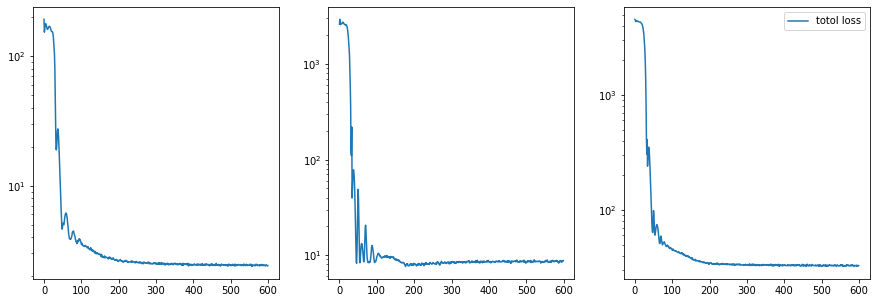

tensor(8.7519)


In [6]:

plot_loss_all(llh_record,v_pen_record)
print(v_pen_record[-1])
